<h2 style="color:blue" align="center">Quantization Tutorial</h2>

Quantization is a technique to downsize a trained model so that you can deploy it on EDGE devices. In this tutorial we will,

(1) Train a hand written digits model

(2) Export to a disk and check the size of that model

(3) Use two techniques for quantization (1) post training quantization (3) quantization aware training

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
(X_train, y_train) , (X_test, y_test) = keras.datasets.mnist.load_data()

In [3]:
len(X_train)

60000

In [4]:
len(X_test)

10000

In [5]:
X_train[0].shape

(28, 28)

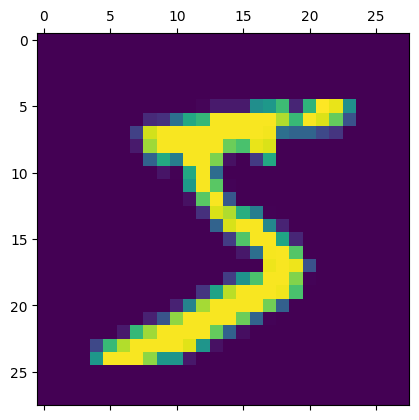

In [6]:
plt.matshow(X_train[0])

In [7]:
y_train[0]

5

In [8]:
X_train = X_train / 255
X_test = X_test / 255

In [9]:
X_train_flattened = X_train.reshape(len(X_train), 28*28)
X_test_flattened = X_test.reshape(len(X_test), 28*28)

In [10]:
X_train_flattened.shape

(60000, 784)

<h3 style='color:purple'>Using Flatten layer so that we don't have to call .reshape on input dataset</h3>

In [11]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 9s 4ms/step - loss: 0.2749 - accuracy: 0.9222
Epoch 2/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1226 - accuracy: 0.9640
Epoch 3/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0857 - accuracy: 0.9741
Epoch 4/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0647 - accuracy: 0.9797
Epoch 5/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0497 - accuracy: 0.9847


In [12]:
model.evaluate(X_test,y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0820 - accuracy: 0.9751


[0.0820368081331253, 0.9750999808311462]

In [14]:
model.save("./saved_model/") # Saving the model -- the size of the directory is about 1 MB

INFO:tensorflow:Assets written to: ./saved_model/assets


INFO:tensorflow:Assets written to: ./saved_model/assets


<h3 style='color:blue'>(1) Post training quantization</h3>

**Without quantization**

In [15]:
converter = tf.lite.TFLiteConverter.from_saved_model("./saved_model") # we have to supply the directory
tflite_model = converter.convert()

In [16]:
# to check the size of the model
len(tflite_model) ## it is around 312 KB

320004

**With quantization**

In [17]:
converter = tf.lite.TFLiteConverter.from_saved_model("./saved_model") # we have to supply the directory
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

In [18]:
# to check the size of the quantized model
len(tflite_quant_model)

84880

Read this article for post training quantization: https://www.tensorflow.org/model_optimization/guide/quantization/post_training

In [19]:
len(tflite_model)

320004

In [20]:
len(tflite_quant_model)

84880

You can see above that quantizated model is 1/4th the size of a non quantized model

In [23]:
with open("tflite_model.tflite", "wb") as f: ## saving the lite model
    f.write(tflite_model)
# without quantization -- 312 KB

In [24]:
with open("tflite_quant_model.tflite", "wb") as f: # saving the quantized lite model
    f.write(tflite_quant_model)
# with quantization -- 83 KB

Once you have above files saved to a disk, check their sizes. Quantized model will be obvi

<h3 style='color:blue'>(2) Quantization aware training</h3>

In [26]:
import tensorflow_model_optimization as tfmot ## Calling the model optimizer

quantize_model = tfmot.quantization.keras.quantize_model # using the quantize model method

# q_aware stands for for quantization aware.
q_aware_model = quantize_model(model) # Calling the regular model

# `quantize_model` requires a recompile.
q_aware_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

q_aware_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer (QuantizeLa  (None, 28, 28)            3         
 yer)                                                            
                                                                 
 quant_flatten (QuantizeWra  (None, 784)               1         
 pperV2)                                                         
                                                                 
 quant_dense (QuantizeWrapp  (None, 100)               78505     
 erV2)                                                           
                                                                 
 quant_dense_1 (QuantizeWra  (None, 10)                1015      
 pperV2)                                                         
                                                                 
Total params: 79524 (310.64 KB)
Trainable params: 79510 

In [27]:
q_aware_model.fit(X_train, y_train, epochs=1) # training the quantized lite model with 1 epoch

1875/1875 [==============================] - 11s 5ms/step - loss: 0.0428 - accuracy: 0.9871


In [28]:
q_aware_model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0796 - accuracy: 0.9756


[0.07955561578273773, 0.975600004196167]

In [30]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model) # Do the tf_lite conversion
converter.optimizations = [tf.lite.Optimize.DEFAULT] # Using the quantization optimization

tflite_qaware_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\Admin\AppData\Local\Temp\tmp01oh9htt\assets


INFO:tensorflow:Assets written to: C:\Users\Admin\AppData\Local\Temp\tmp01oh9htt\assets
C:\Users\Admin\anaconda3\envs\geo_env\Lib\site-packages\tensorflow\lite\python\convert.py:947: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [31]:
len(tflite_qaware_model)

82736

In [33]:
with open("tflite_qaware_model.tflite", 'wb') as f:
    f.write(tflite_qaware_model)
# with quantization aware lite model we got the size of 81 KB